# maximally activating stimulus

This notebook creates a stimulus that optimally drives each neuron. A deep learning model is trained to predict neural response; then, gradient ascent is used to optimize an image to maximally activate each node in the final layer corresponding to each neuron. The result is a set of images, one for each neuron, that maximally activates each neuron.

For a more detailed description on maximally activating stimuli, check out the paper "Inception loops discover what excites neurons using deep predictive models." [(Link.)](https://www.nature.com/articles/s41593-019-0517-x?proof=t)


# part one: train deep neural net

## import libraries

In [1]:
import os, sys, mkl  
mkl.set_num_threads(10)
import numpy as np 
from scipy import io 
from matplotlib import pyplot as plt 
from scipy.stats import zscore

## load and process data with rastermap

Here, we use [rastermap](https://github.com/MouseLand/rastermap) clustering to preprocess the data into 1000 "super neurons." The maximally activating stimuli will correspond to each superneuron.

This step is not necessary to create maximally activating neurons, which can alternatively be created directly from the neural data, without rastermap preprocessing. Alternatively, you can use k-means clustering or some other preprocessing technique before creating the maximally activating stimuli.

In [2]:
path = '/groups/pachitariu/pachitariulab/datasets/txt5k_3x/'
dat = np.load(path + 'TX61_3x.npz') # neural data
dstim = io.loadmat(path + 'text5k_3x.mat', squeeze_me=True) # stimulus data
spks = dat['spks']


In [3]:
print("original spks shape", spks.shape) # neurons x timepoints 

original spks shape (69957, 32468)


In [4]:
# train/test splits for testing rastermap
import sys
sys.path.append('/groups/stringer/home/josephs2/rastermap')
import rastermap
from rastermap.mapping_landmark import Rastermap
from rastermap.utils import split_testtrain
itrain, itest = split_testtrain(spks.shape[1])

In [5]:
from rastermap import mapping_landmark
model = mapping_landmark.Rastermap(n_clusters=200).fit(spks, itrain=itrain)

n_PCs = 200 computed, time 26.75
landmarks computed and embedded, time 137.36
grid upsampled, time 139.98


In [6]:
from rastermap.metrics import embedding_score
mnn, rho = embedding_score(model.X_test, model.embedding)
print('local/global scores: %2.3f; %2.3f'%(mnn[0], rho))

local/global scores: 0.149; 0.265


In [7]:
# bin rastermap by neurons
nbins = 1000

y = model.embedding[:,0]
isort = np.argsort(y)
imax = np.arange(y.size)//(y.size/nbins)

NT = spks.shape[1]
xbin = np.zeros((nbins, NT))
for j in range(nbins):
    xbin[j] = spks[isort[imax==j]].mean(0)

In [8]:
# sort xbin into stimuli and average over the three repeats
iss = np.zeros((3,5000), 'int32')
for j in range(5000):
    iss[:,j] = (dat['istim']==j).nonzero()[0][:3]
    
x = xbin[:, dat['frame_start']]
x = x[:, iss].transpose((1,0,2))

xzz = zscore(x, 2)
snr = (xzz[0] * xzz[1]).mean(1) # this is the stimulus correlation across repeats, or "SNR"

x = x.mean(0)
x = zscore(x, 1)

print("x shape", x.shape)

x shape (1000, 5000)


In [9]:
# preprocess image data 
from sklearn.decomposition import TruncatedSVD
import cv2

nb = 100
Ly, Lx = 24, 84
img = np.zeros((5000, Ly, Lx))
for j in range(5000//nb):
    img[j*nb:(j+1)*nb] = cv2.resize(dstim['img'][:,:,j*nb:(j+1)*nb], (2*42, 2*12)).transpose((2,0,1))

# all the receptive fields are on the front left monitor
img = img[:,:,40:-10]
img = img - img.mean(0) # center the data
img = img / (img**2).mean() **.5

nimg, Ly, Lx = img.shape
print(img.shape)

(5000, 24, 34)


### split into training and test for the deep neural net

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

X = img.reshape(-1, 1, 24, 34)
Y = x.T

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X_train, X_test, y_train, y_test = [torch.Tensor(x) for x in train_test_split(X, Y, random_state=42, shuffle=True)] # train/test
X_train, X_val, y_train, y_val = [torch.Tensor(x) for x in train_test_split(X_train, y_train, random_state=42, shuffle=True)] # train/validation

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

batch_size = 4
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, num_workers=96)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True, num_workers=96)

X shape: (5000, 1, 24, 34)
Y shape: (5000, 1000)

X_train shape: torch.Size([2812, 1, 24, 34])
X_test shape: torch.Size([1250, 1, 24, 34])

y_train shape: torch.Size([2812, 1000])
y_test shape: torch.Size([1250, 1000])


### create deep neural net (CNN)

We use a simple CNN here, but you can put your own deep learning model in this section. The maximally activating stimuli generation process is the same across deep neural nets.

In [11]:
import torch
from torch import nn

import functools
import operator

# use these functions to calculate the shape and size of the CNN outputs
def shape_of_output(shape_of_input, list_of_layers):
    sequential = nn.Sequential(*list_of_layers)
    return tuple(sequential(torch.rand(1, *shape_of_input)).shape)

def size_of_output(shape_of_input, list_of_layers):
    return functools.reduce(operator.mul, list(shape_of_output(shape_of_input, list_of_layers)))

###  pick a CNN
We can either go with the simple 1-layer CNN, the multi-layer CNN, or a deep learning model of your own design.

**Remember to comment out the CNNs you are not using!**

In [12]:
from torch import nn

class CNN(nn.Module):
    """
    Args:
        num_neurons (int): Number of neurons in final layer.
    """
    
    def __init__(self, num_neurons, channels=30, kernel_size=4, padding=2, stride=1, max_pool=4):
        super(CNN, self).__init__()
        
        self.num_neurons = num_neurons
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.MaxPool2d(max_pool),
        )
        
        self.output = nn.Sequential(
            nn.Linear(size_of_output(X_train[0].shape, self.cnn), self.num_neurons, bias=True),
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        return x
    


In [13]:
kk = [32, 32, 32, 32] # number of channels of hidden conv2d layers

class MultiCNN(nn.Module):
    def __init__(self, num_neurons=1000, k = 7, c_in = 1, c_out = 32, size_pool = 2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(c_in, kk[0], kernel_size=k, padding=k//2, stride=1) # n x 8
        self.batch1 = nn.BatchNorm2d(kk[0])
        self.conv2 = nn.Conv2d(kk[0], kk[1], kernel_size=3, padding=1, stride=1) # n x 8
        self.batch2 = nn.BatchNorm2d(kk[1])
        self.conv3 = nn.Conv2d(kk[1], kk[2], kernel_size=3, padding=1, stride=1) # n x 8
        self.batch3 = nn.BatchNorm2d(kk[2])
        self.conv4 = nn.Conv2d(kk[2], kk[3], kernel_size=3, padding=1, stride=1) # n x 8
        self.batch4 = nn.BatchNorm2d(kk[3])

        self.batch_o2 = nn.BatchNorm2d(kk[2])
        self.fc2 = nn.Linear(self.get_shape(X_train)[1], num_neurons, bias=True)
        
    def get_shape(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch2(self.conv2(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch3(self.conv3(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch4(self.conv4(x)))
        x = self.batch_o2(x)
        
        x = x.reshape( -1, x.shape[1] * x.shape[2]*x.shape[3])
        return x.shape
        

    def forward(self, x, fc=False):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch2(self.conv2(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch3(self.conv3(x)))
        x = F.avg_pool2d(x, 2)

        x = x + F.relu(self.batch4(self.conv4(x)))
        x = self.batch_o2(x)
        
        x = x.reshape( -1, x.shape[1] * x.shape[2]*x.shape[3])
        x = self.fc2(x)

        return x

def total_variation_loss(x):
    a = torch.square(x[:, :, :-1, :] - x[:, :, 1:, :]).mean((-2,-1))
    b = torch.square(x[:, :, :, :-1] - x[:, :, :, 1:]).mean((-2,-1))
    loss = (torch.pow(a + b, 1.25)).mean(-1)
    return loss


In [14]:
from scipy.stats import pearsonr
def pearson(pred, true):
    """
    Neuron-by-neuron Pearson's correlation to measure
    overall score.
    
    Args:
        pred 
        true
    """
    total_pearson = defaultdict(float)
    for i in range(pred.shape[1]):
        r, p = pearsonr(pred[:,i], true[:,i])
        total_pearson[i] = r
    return np.mean(list(total_pearson.values()))

### train deep neural net

We train a deep neural net for 200 epochs, but you are encouraged to tailor the hyperparameters to your model.

In [82]:
from tqdm import tqdm
from torch import optim
from collections import defaultdict
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


# net=CNN(num_neurons=1000)
net = MultiCNN(num_neurons=1000)

epochs = 100
optimizer = optim.SGD(net.parameters(), lr=6e-5, momentum=0.9,
                     weight_decay=.01)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_loss, train_acc, val_loss, val_acc = [], [], [], []

for epoch in range(epochs):
    
    # Training
    running_train_loss = 0.0
    running_pearson = 0.0
    total = 0
    t = tqdm(train_loader)
    t.set_description("Epoch {} - Training".format(epoch))
    for data in t:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        running_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        total += 1   
        
        p = pearson(outputs.detach().numpy(), labels.detach().numpy())
        running_pearson += p
        
    scheduler.step() 
    
    epoch_loss = running_train_loss / total
    epoch_acc = running_pearson / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    # Validation
    if epoch % 15 == 0:
        print("Epoch {}. Train loss {}. Train Pearson's {}".format(epoch, epoch_loss, epoch_acc))

        running_val_loss = 0.0
        running_pearson = 0.0
        total = 0 
        v = tqdm(val_loader)
        v.set_description("Validating")
        for data in v:
            inputs, labels = data
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            p = pearson(outputs.detach().numpy(), labels.detach().numpy())
            running_pearson += p
            total += 1

        epoch_loss = running_val_loss / total
        epoch_acc = running_pearson / total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print("Epoch {}. Validation loss {}. Validation Pearson's {}".format(epoch, epoch_loss, epoch_acc))


### view loss curves

We plot the loss to make sure that the training process was effective. If training was successful, our loss should should decrease, then plateau.

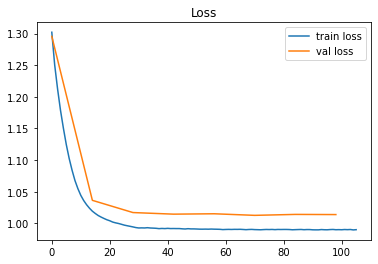

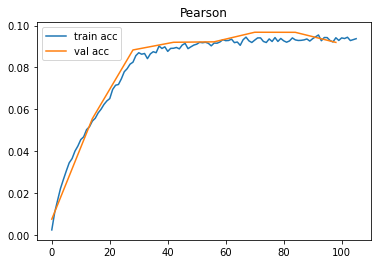

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Loss")
plt.plot(range(len(train_loss)), train_loss, label="train loss")
interval = int(len(train_loss) / len(val_loss)) + 1
plt.plot(range(0, len(train_loss), interval), val_loss, label="val loss")
plt.legend()


plt.figure()
plt.title("Pearson")
plt.plot(range(len(train_acc)), train_acc, label="train acc")
plt.plot(range(0, len(train_acc), interval), val_acc, label="val acc")
plt.legend()

### view neuron-by-neuron pearson's correlation

We calculate the Pearson's correlation for each neuron (node by node of the final layer of the neural net) by comparing the test data with our neural net's predictions.

In [26]:
# Reload model
from collections import defaultdict
from scipy.stats import pearsonr

# Evaluate model
device='cuda'
net.eval()
net.to(device)
batch_size=4
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False, num_workers=96)

y_pred_matrix = []
y_test_matrix = []
for batch in test_loader:
    x_te, y_te = batch
    x_te, y_te = x_te.to(device), y_te.to(device)
    y_pred = net(x_te)
    y_pred_matrix.append(y_pred.detach().cpu())
    y_test_matrix.append(y_te)

y_pred_matrix, y_test_matrix = torch.cat(y_pred_matrix).cpu().numpy(), torch.cat(y_test_matrix).cpu().numpy()


Calculating pearson's for 1000 clusters


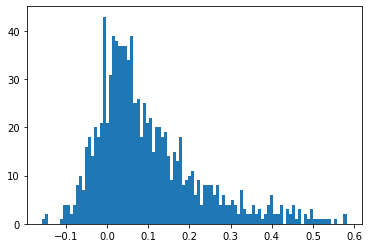

In [31]:
total_pearson = defaultdict(float)
print("Calculating pearson's for", y_pred_matrix.shape[1], "clusters")
for n in range(y_pred_matrix.shape[1]):
    r, p = pearsonr(y_pred_matrix[:,n], y_test_matrix[:,n])
    total_pearson[n] = r

len(total_pearson)
values = total_pearson.values()
plt.figure()
hist = plt.hist(values, bins=100)


In [32]:
print("Mean pearson's {}".format(np.mean(list(values))))


Mean pearson's 0.09818145254410332


# part two: create maximally activating stimuli

### create maximally activating stimuli function

In [60]:
import cv2
from torch.autograd import Variable

class VisualizeNeuron():
    def __init__(self, model):
        self.device = "cuda"
        self.model = model.to(self.device).eval()
    
    def visualize(self, neuron, Lyd, Lxd, iterations=10e4, lr=.3):

        # Generate random image
        img_var = np.uint(np.random.uniform(150, 180, (Lyd, Lxd))) / 255
        img_var = img_var.reshape(1, Lyd, Lxd)
            
        # Run gradient ascent
        img_var = Variable(torch.Tensor(img_var[None]), requires_grad=True)
        iterations = int(10e4)
        total_loss = []
        for i in range(iterations):
            if i / 1000 == 0:
                print("On iteration: {}".format(i))
            output = self.model(img_var.to(self.device))
            loss = -output[:,neuron]
            total_loss.append(loss)
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        img_var = img_var.data.cpu().numpy()
        return img_var, total_loss

### plot maximally activating stimuli and visualize loss

As with training the original net, ensure that the loss curve plateaus out, so that we know training is converging.

(1, 24, 34)
On iteration: 0


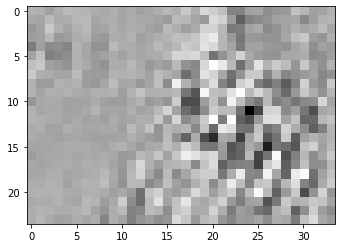

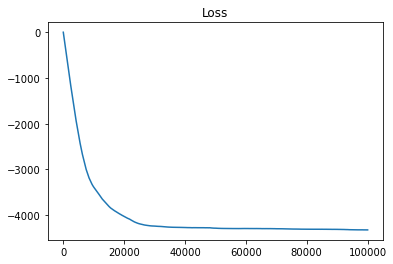

In [67]:
Lyd, Lxd = 24, 34
img, total_loss = VisualizeNeuron(model=net).visualize(0, Lyd, Lxd, iterations=1000, lr=.5)
plt.figure()
plt.imshow(img.reshape(Lyd, Lxd), cmap="gray")

plt.figure()
plt.title("Loss")
plt.plot(total_loss)

(1, 24, 34)
On iteration: 0


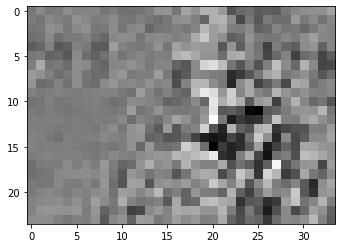

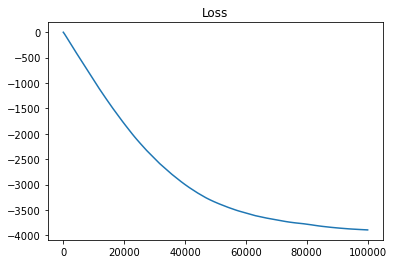

In [69]:
img, total_loss = VisualizeNeuron(model=net).visualize(0, Lyd, Lxd, iterations=1000, lr=.1)
plt.figure()
plt.imshow(img.reshape(Lyd, Lxd), cmap="gray")

plt.figure()
plt.title("Loss")
plt.plot(total_loss)

#### plot most predictive neurons based on Pearson's

In [70]:
# get most predictive neurons based on Pearson's
from scipy.stats import pearsonr
# total_r = []
# for i,j in zip(dat['y_test'], dat['y_pred']):
#     r, p = pearsonr(i, j)
#     total_r.append(r)
indices = np.argsort(list(values))[::-1]
# indices

In [71]:
neurons_picked = 10
# neuron_list = np.random.choice(NN, size=neurons_picked)
# neuron_list 
neuron_list = indices[:neurons_picked]

In [76]:
vn = VisualizeNeuron(net)
total_stimuli = []
total_loss = []
for neuron in neuron_list:
    print("On neuron {}".format(neuron))
    img, loss = vn.visualize(neuron, Lyd, Lxd, iterations=500, lr=.3)
    total_stimuli.append(img)
    total_loss.append(loss)


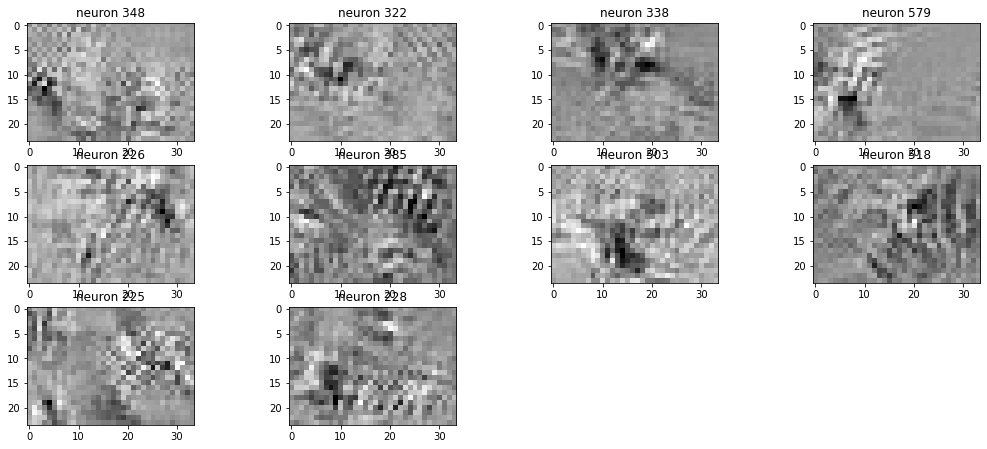

In [74]:
plt.figure(figsize=(18,10))
for j, (n,stim) in enumerate(zip(neuron_list,total_stimuli)):
    vl = np.max(np.abs(stim))
    plt.subplot(4,4,j+1)
    plt.imshow(stim.reshape(Lyd, Lxd), cmap='gray')
    plt.title("neuron {}".format(n))

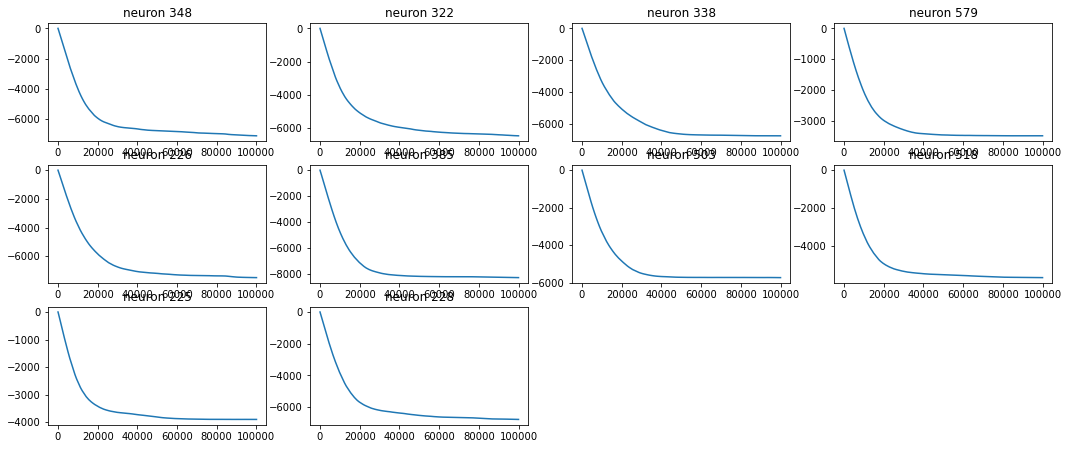

In [75]:
plt.figure(figsize=(18,10))
for j, (n, loss) in enumerate(zip(neuron_list, total_loss)):
    plt.subplot(4,4,j+1)
    plt.plot(loss)
    plt.title(str("neuron {}".format(n)))

# part 3: optional analyses

## [optional] save data for future use 

In [ ]:
# save neural net

# SET NAME
NAME = # enter name here

# SET OUTPUT DIRECTORY
torch.save({"model_state_dict": net.state_dict()}, "save_models/" + NAME)
print("Model saved.")
new_dat = {}
new_dat['X_train'] = X_train
new_dat['y_train'] = y_train
new_dat['X_val'] = X_val
new_dat['y_val'] = y_val
new_dat['X_test'] = X_test
new_dat['y_test'] = y_test
new_dat['y_pred'] = y_pred_matrix
np.save("save_models/" + NAME + "_DATA", new_dat)
print("Data saved.")

In [ ]:
# load model
import torch

model_path = "save_models/" + NAME
checkpoint = torch.load(model_path)
# prepare model
cnn_model = CNN(num_neurons=1000)
cnn_model.load_state_dict(checkpoint['model_state_dict'])

## [optional] view neural trace

We plot out a neural trace of our most predictive neuron to get a sense of the accuracy of our deep learning model. We can see that our current model does not capture the neuron's highest spikes.

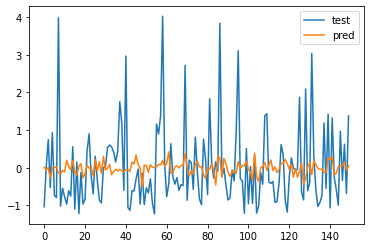

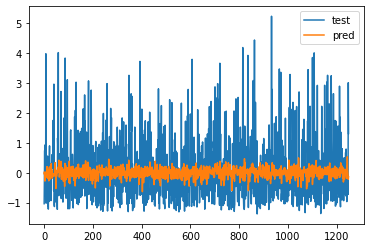

In [33]:
plt.figure()
plt.plot(y_test_matrix[:150,0], label="test")
plt.plot(y_pred_matrix[:150,0], label="pred")
plt.legend()

plt.figure()
plt.plot(y_test_matrix[:,0], label="test")
plt.plot(y_pred_matrix[:,0], label="pred")
plt.legend()

#### top-performing neuron

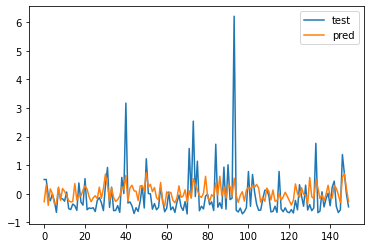

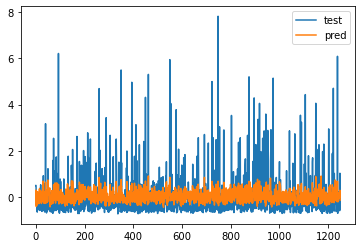

In [34]:
# top performing neuron
indices = np.argsort(list(values))[::-1]

n = indices[0]

plt.figure()
plt.plot(y_test_matrix[:150,n], label="test")
plt.plot(y_pred_matrix[:150,n], label="pred")
plt.legend()

plt.figure()
plt.plot(y_test_matrix[:,n], label="test")
plt.plot(y_pred_matrix[:,n], label="pred")
plt.legend()

## [optional] view rastermap

(0.0, 0.8)

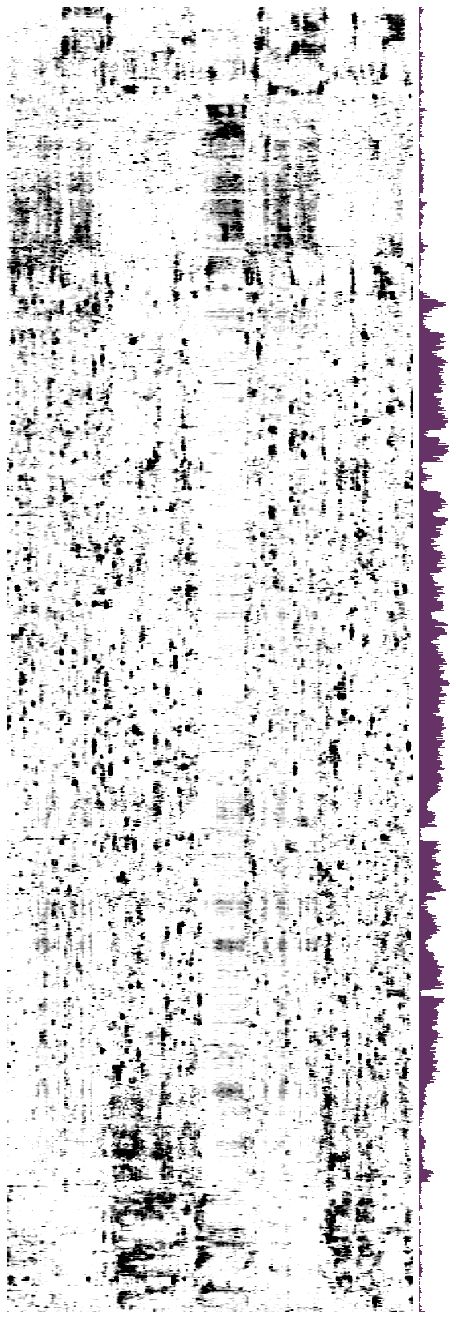

In [79]:
# for rastermap display
xz = xbin.copy()
xz = xz - np.mean(xz, 0)
xz = zscore(xz, 1)

# # for receptive field display
# rf = rfs[200]
# vv = 2 * np.maximum(rf.max(), -rf.min())
# nn = 90


# in order: a) rastermap, b) stim SNR, c) regression corr d) RFs (sub-sampled), e) all consecutive RFs (positions 220-310)
plt.figure(figsize=(16,24))
plt.subplot(1,2,1)
plt.imshow(xz[:, 5000:5200], vmin=0, vmax=2, cmap = 'gray_r', aspect='auto')
plt.axis('off')

plt.subplot(1, 24, 12)
plt.barh(np.arange(len(snr))[::-1], snr, 1, color = [.4, .2,.4])
plt.axis('off')
plt.ylim([0, len(snr)-1])
plt.xlim([0, .8])

Text(0, 0.5, 'y position (um)')

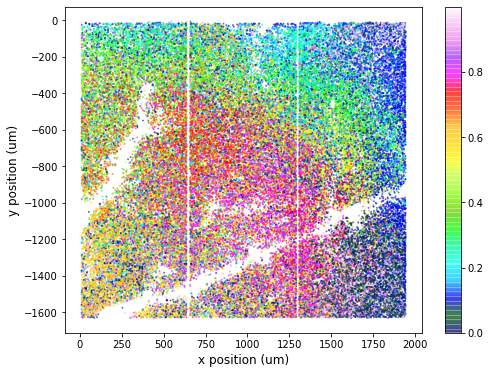

In [80]:
# rastermap position in tissue
xpos = dat['xpos']
ypos = dat['ypos']

plt.figure(figsize=(8,6))

plt.scatter(xpos, -ypos, s = 1, c = model.embedding[:,0]/200, cmap = 'gist_ncar', alpha=.5)
plt.colorbar()
plt.xlabel('x position (um)', fontsize=12)
plt.ylabel('y position (um)', fontsize=12)

#plt.savefig('D:/Github/rastercode/fig/xypos_fov_rmap.png', bbox_inches='tight', transparent=True)

## [optional] visualize filters

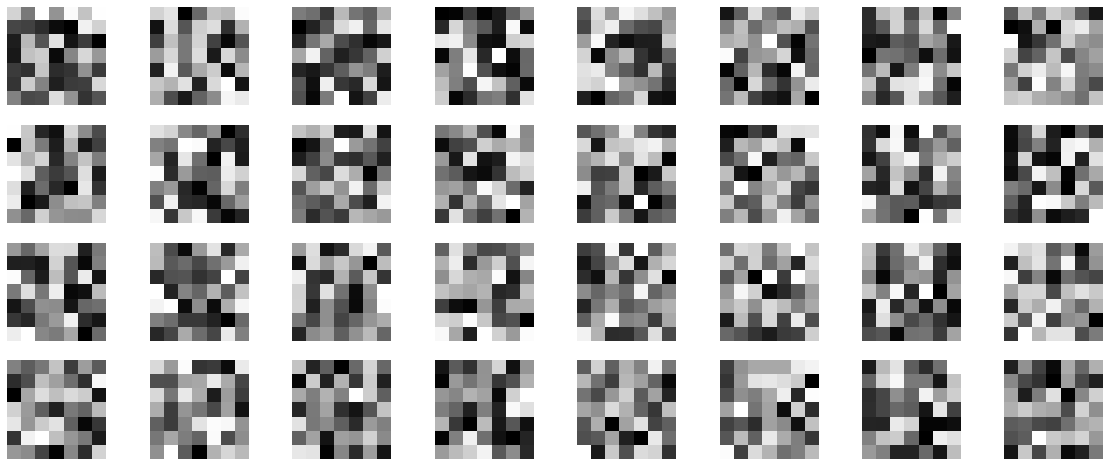

In [88]:
plt.figure(figsize=(20, 17))
for i, fil in enumerate(net.conv1.weight):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(fil[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()